## Import Statements

In [1]:
import re
import eleanor

import matplotlib.pyplot as plt
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
plt.rcParams['figure.dpi'] = 300

import numpy as np

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord

from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = 5

In [3]:
import pyvo as vo

In [4]:
import pandas as pd

## TESS Source

In [16]:
tess_str = 'S6TIC' + '31181005'

tess_list = re.split(r'(\d+)', tess_str)
tic = int(tess_list[3])
sec = int(tess_list[1])

In [17]:
star = eleanor.Source(tic=tic, sector=sec)

print('\nTESS: Found TIC {0} (Gaia DR2 {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'.format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-4-3-cal-1294-1672_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-4-3-cal-1294-1672_tess_v2_bkg.fits with expected size 61162560. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-4-3-cal-1294-1672_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-4-3-cal-1294-1672_tess_v2_pc.fits with expected size 122411520. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-4-3-cal-1294-1672_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-4-3_tess_v2_pm.txt with expected size 185304. [astroquery.query]

TESS: Found TIC 31181005 (Gaia DR2 4661291482014488064), with TESS magnitude 14.9958, RA 76.6590013495217, and Dec -68.4195251957768


## GAIA Cross-Match

In [18]:
coord = SkyCoord(ra=star.coords[0], dec=star.coords[1], unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(1.0, u.arcsec)

job = Gaia.cone_search_async(coord, radius)
results = job.get_results()

gaia = int(str(results[0][1])[8:])
print('\nGAIA: ' + str(gaia))

INFO: Query finished. [astroquery.utils.tap.core]

GAIA: 4661291482014488064


In [19]:
query_str = "SELECT source.* " + "FROM gaiadr3.gaia_source as source " + "WHERE source.source_id='" + str(gaia) + "'"
job = Gaia.launch_job(query_str)
results = job.get_results()

if results['has_epoch_photometry'][0]:
    print('GAIA: Has epoch photometry.')
else:
    print('GAIA: Does not have epoch photometry.')

GAIA: Has epoch photometry.


## ZTF Cross-Match

In [20]:
url = vo.dal.SCSService('https://irsa.ipac.caltech.edu/SCS?table=ztf_objects_dr12')
coord_z = SkyCoord(star.coords[0], star.coords[1], unit=(u.deg,u.deg))

results_ztf = url.search(pos=coord_z, radius=radius)
results_ztf.to_table().to_pandas()

num_good = results_ztf['ngoodobs'].sum()
print('ZTF: ' + str(num_good) + ' good observations found.')

ZTF: -- good observations found.


## TESS Lightcurve

In [21]:
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_pca=True, regressors='corner')

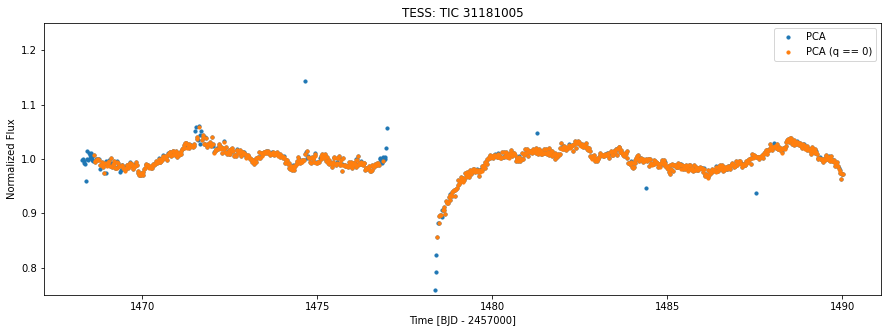

In [22]:
plt.figure(figsize=(15,5))

plt.scatter(data.time, data.pca_flux/np.nanmedian(data.pca_flux), label='PCA', s=10)

# quality mask (optional)
q = data.quality == 0
plt.scatter(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), label='PCA (q == 0)', s=10)

plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.ylim(0.75, 1.25)
plt.title('TESS: TIC ' + str(tic))
plt.legend()

## GAIA Lightcurve

In [12]:
datalink = Gaia.load_data(ids=gaia, data_release = 'Gaia DR3', data_structure = 'COMBINED', retrieval_type = 'EPOCH_PHOTOMETRY', valid_data=True)

dl_key = [i for i in datalink.keys()][0]
print(f'The following Datalink product has been downloaded: * {dl_key}')

The following Datalink product has been downloaded: * EPOCH_PHOTOMETRY-Gaia DR3 3016976485469132800.xml


In [13]:
epoch_phot = datalink[dl_key][0].to_table().to_pandas()

g_phot = epoch_phot[epoch_phot['band'] == 'G']
bp_phot = epoch_phot[epoch_phot['band'] == 'BP']
rp_phot = epoch_phot[epoch_phot['band'] == 'RP']

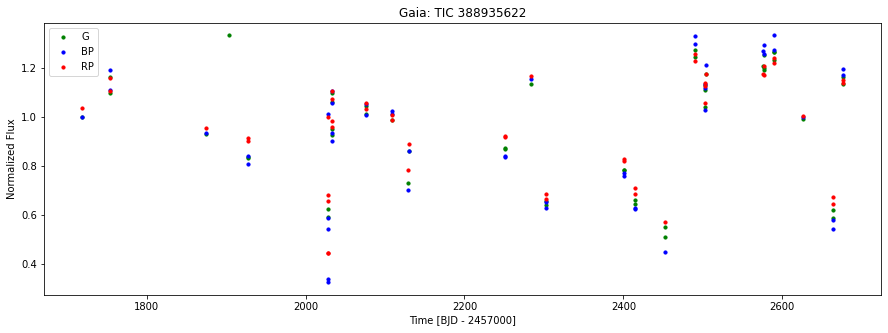

In [14]:
plt.figure(figsize=(15,5))

plt.scatter(g_phot['time'], g_phot['flux']/np.nanmedian(g_phot['flux']), label='G', color='green', s=10)
plt.scatter(bp_phot['time'], bp_phot['flux']/np.nanmedian(bp_phot['flux']), label='BP', color='blue', s=10)
plt.scatter(rp_phot['time'], rp_phot['flux']/np.nanmedian(rp_phot['flux']), label='RP', color='red', s=10)

plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.title('Gaia: TIC ' + str(tic))
plt.legend()

## ZTF Lightcurve

In [15]:
from ztfquery import lightcurve

In [16]:
from ztfquery import io
io.set_account("irsa")  # astronomcody@gmail.com, cepheid

In [17]:
lcq = lightcurve.LCQuery.from_position(star.coords[0], star.coords[1], 1)

In [18]:
lcq.data['time'] = lcq.data['mjd'] + 2400000.5 - 2457000
zg_phot = lcq.data[lcq.data['filtercode'] == 'zg'].sort_values('time')
zr_phot = lcq.data[lcq.data['filtercode'] == 'zr'].sort_values('time')

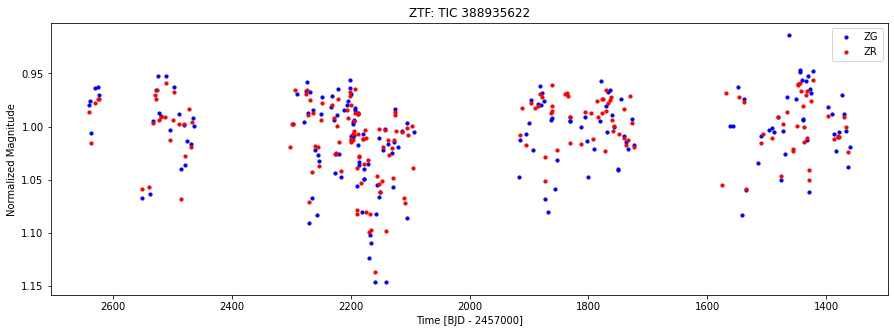

In [19]:
plt.figure(figsize=(15,5))

plt.scatter(zg_phot['time'], zg_phot['mag']/np.nanmedian(zg_phot['mag']), label='ZG', color='blue', s=10)
plt.scatter(zr_phot['time'], zr_phot['mag']/np.nanmedian(zr_phot['mag']), label='ZR', color='red', s=10)

plt.ylabel('Normalized Magnitude')  # look into converting to flux
plt.xlabel('Time [BJD - 2457000]')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title('ZTF: TIC ' + str(tic))
plt.legend()

## GAIA Extinction

In [20]:
bp_rp_phot = pd.merge_asof(bp_phot, rp_phot, on='time', tolerance=1, direction='nearest').dropna()  # throw out matches > 1 day
bp_sub_rp_phot = bp_rp_phot['flux_x'] - bp_rp_phot['flux_y'].values

rp = bp_rp_phot['flux_y']/np.nanmedian(bp_rp_phot['flux_y'])
bp_sub_rp = bp_sub_rp_phot/np.nanmedian(bp_sub_rp_phot)

fit = np.polyfit(rp, bp_sub_rp, 1)
x = np.linspace(rp.min(),rp.max(),100)
y = fit[0]*x+fit[1]
fit_eq = 'y=' + '{:.2f}'.format(fit[0]) + 'x+' + '{:.2f}'.format(fit[1])

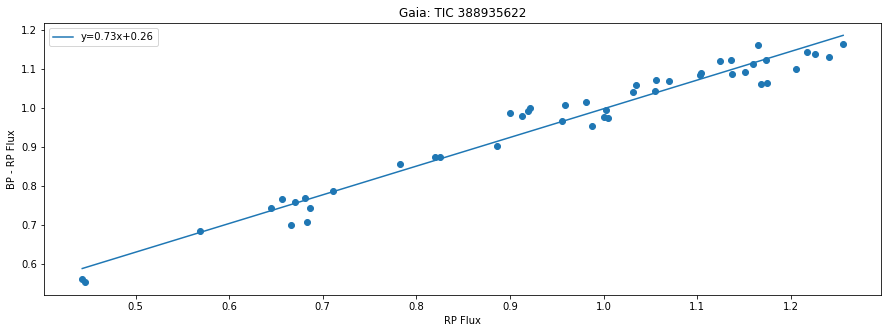

In [21]:
plt.figure(figsize=(15,5))

plt.scatter(rp, bp_sub_rp)
plt.plot(x, y, label=fit_eq)

plt.ylabel('BP - RP Flux')
plt.xlabel('RP Flux')

plt.title('Gaia: TIC ' + str(tic))
plt.legend(loc='upper left')

## ZTF Extinction

In [22]:
zg_zr_phot = pd.merge_asof(zg_phot, zr_phot, on='time', tolerance=1, direction='nearest').dropna()  # throw out matches > 1 day
zg_sub_zr_phot = zg_zr_phot['mag_x'] - zg_zr_phot['mag_y'].values

zr = zg_zr_phot['mag_y']/np.nanmedian(zg_zr_phot['mag_y'])
zg_sub_zr = zg_sub_zr_phot/np.nanmedian(zg_sub_zr_phot)

fit = np.polyfit(zr, zg_sub_zr, 1)
x = np.linspace(zr.min(),zr.max(),100)
y = fit[0]*x+fit[1]
fit_eq = 'y=' + '{:.2f}'.format(fit[0]) + 'x+' + '{:.2f}'.format(fit[1])

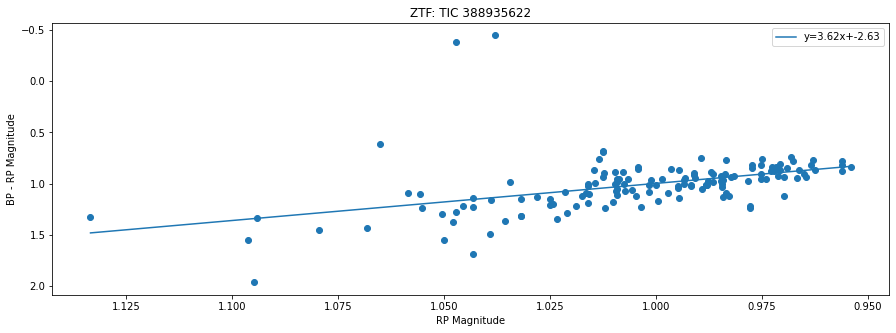

In [23]:
plt.figure(figsize=(15,5))

plt.scatter(zr, zg_sub_zr)
plt.plot(x, y, label=fit_eq)

plt.ylabel('BP - RP Magnitude')
plt.xlabel('RP Magnitude')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title('ZTF: TIC ' + str(tic))
plt.legend(loc='upper right')